In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc, dados_especificos_coluna
from include.graficos import montar_graficos, montar_grafico_correlacao
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo de regressão para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Desenvolver um modelo preditivo de regressão que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Qual é o impacto da região de residência no custo médico individual?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Esses dados serão utilizados para desenvolver um modelo preditivo de regressão para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação) e MAE (erro absoluto médio) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

**Sumário dos Dados:**

In [3]:
# leia os dados CSV indicados no site da FIAP
dados = pd.read_csv('../base_dados.csv', encoding='latin-1')

# aqui chamo a função incrementar_dados_aleatorios, para aumentar o volume da variável dados
dados = incrementar_dados_aleatorios_csv(dados)

# Aplicar a função para categorizar IMC e criar uma nova coluna 'Categoria IMC'
dados['Categoria IMC'] = dados['IMC'].apply(categorizar_imc)

print("\nLista de todas colunas:\n\n", list(dados))
print("\nAmostra dos dados:\n\n", dados.head())
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())


Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Filhos', 'Fumante', 'Região', 'Encargos', 'Categoria IMC']

Amostra dos dados:

    Idade     Gênero    IMC  Filhos Fumante    Região   Encargos  \
0   56.0   feminino  29.77     2.0     sim  sudoeste   31109.89   
1   46.0  masculino  25.86     1.0     não  nordeste   26650.70   
2   32.0  masculino  23.01     0.0     não  sudoeste   21459.04   
3    NaN   feminino    NaN     NaN     nan       nan        NaN   
4   70.0  masculino  27.20     3.0     não  sudoeste  187161.98   

    Categoria IMC  
0       Sobrepeso  
1       Sobrepeso  
2     Peso normal  
3  Valor Inválido  
4       Sobrepeso  

Quantidade de linhas: 203. Quantidade de colunas: 8

Tipos de dados das colunas:

 Idade            float64
Gênero            object
IMC              float64
Filhos           float64
Fumante           object
Região            object
Encargos         float64
Categoria IMC     object
dtype: object

Quantidade de valores ausentes por coluna:

**Visualização dos Dados:** gráficos para entender a distribuição e padrões nos dados.

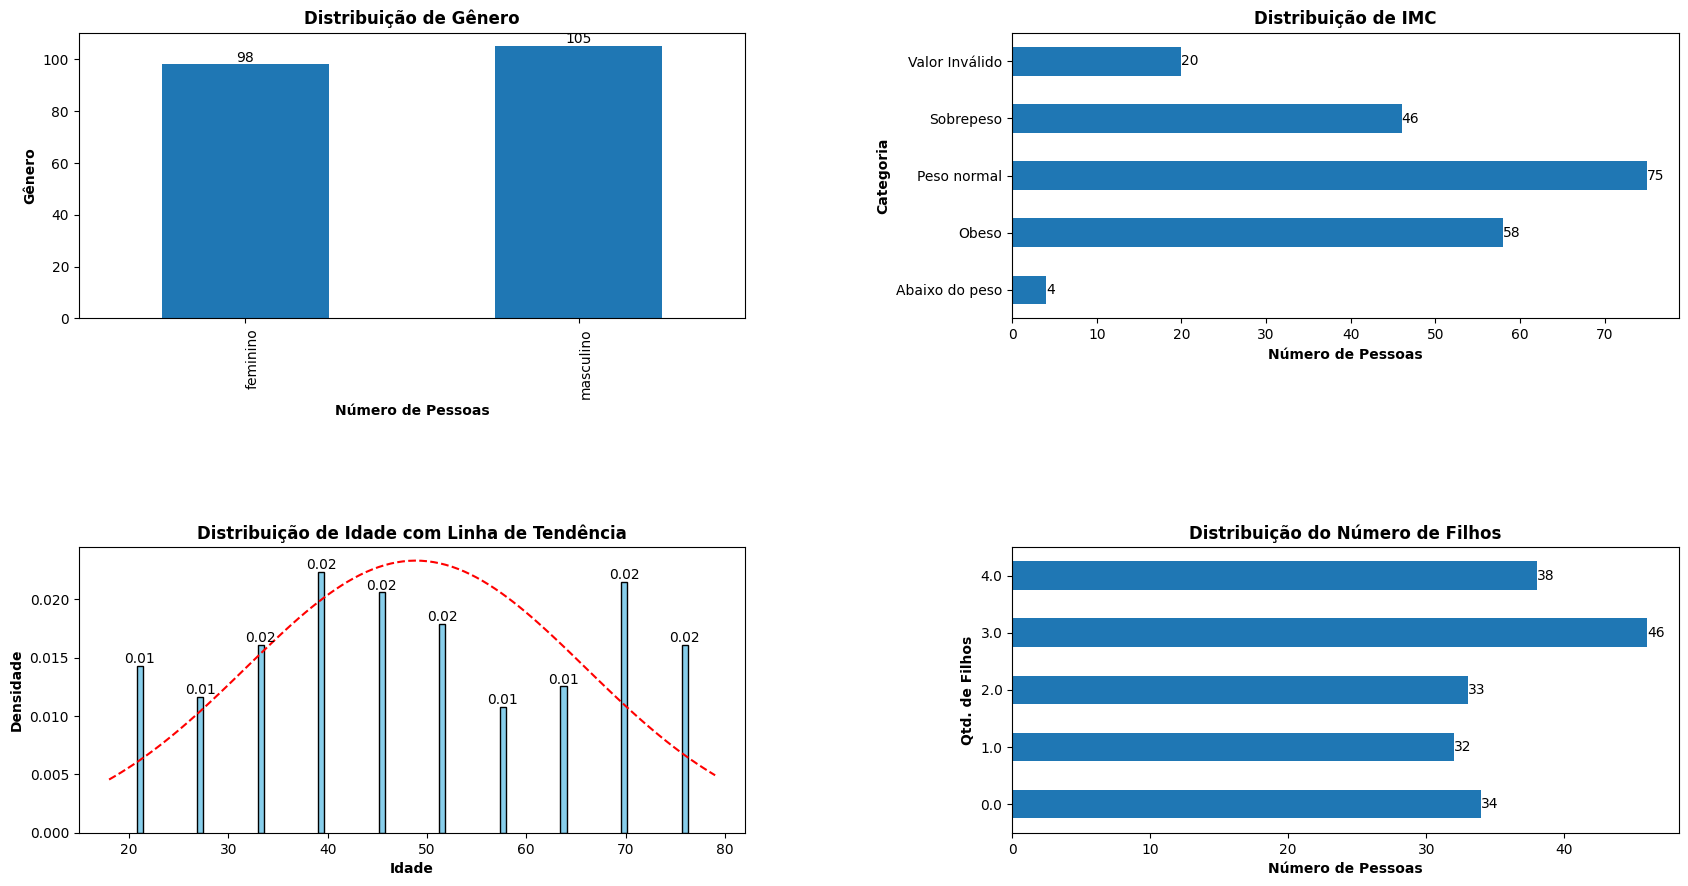

In [4]:
montar_graficos(dados)

**3. Separação dos Dados em Treino e Teste**

In [5]:
# Dividir os dados em features (X) e target (y)
X = dados.drop('Encargos', axis=1)  # Substitua 'target_column_name' pelo nome da coluna alvo
y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[['Gênero', 'Região']])

# Concatenar features codificadas com as restantes
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(['Gênero', 'Região']), index=X.index)
X = pd.concat([X.drop(['Gênero', 'Região'], axis=1), X_encoded], axis=1)

# Codificar variável categórica 'IMC' com LabelEncoder
label_encoder = LabelEncoder()
X['Categoria IMC'] = label_encoder.fit_transform(X['Categoria IMC'])

# Substituir valores 'sim' e 'não' por 1 e 0
X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
                     Idade       IMC    Filhos   Fumante  Categoria IMC  \
Idade             1.000000 -0.023201  0.076142  0.029738      -0.005958   
IMC              -0.023201  1.000000 -0.091439 -0.026574      -0.335982   
Filhos            0.076142 -0.091439  1.000000  0.001861       0.034955   
Fumante           0.029738 -0.026574  0.001861  1.000000       0.024975   
Categoria IMC    -0.005958 -0.335982  0.034955  0.024975       1.000000   
Gênero_masculino -0.042561 -0.090076  0.006174  0.089527       0.076723   
Região_nordeste   0.014170 -0.176984  0.092762 -0.090359      -0.035860   
Região_noroeste  -0.061528  0.050446  0.020605 -0.090499      -0.138924   
Região_sudeste    0.085971  0.062111  0.019423  0.019429      -0.153420   
Região_sudoeste  -0.040692  0.071425 -0.138911  0.167668      -0.109174   

                  Gênero_masculino  Região_nordeste  Região_noroeste  \
Idade                    -0.042561         0.014170        -0.06152

**4. Análise Exploratória de Dados**

**Resumo Estatístico:**

In [6]:
print("\nInformações adicionais sobre os dados:\n\n", dados.describe())

dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Informações adicionais sobre os dados:

             Idade         IMC      Filhos       Encargos
count  183.000000  183.000000  183.000000     183.000000
mean    48.868852   26.458306    2.120219  140861.751585
std     17.100037    5.114334    1.412960   26875.878123
min     18.000000   18.130000    0.000000   21459.040000
25%     36.000000   22.015000    1.000000  128295.050000
50%     48.000000   26.360000    2.000000  142429.730000
75%     65.000000   30.860000    3.000000  158974.465000
max     79.000000   35.000000    4.000000  192735.380000

Na coluna Idade (float64) a faixa dos dados está entre: 18 até 79.
O valor mais frequente na coluna Idade é: 38, que aparece 7 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.13 até 35.0.
O valor mais frequente na coluna IMC é: 29.77, que aparece 3 vezes.

Na coluna Filhos (float64) a faixa dos dados está entre: 1 até 4.
O valor mais frequente na coluna Filhos é: 3, que aparece 46 vezes.

Na coluna Encargos (float64) a faix

**Identificação de Outliers:** 

In [7]:
for coluna in dados.columns:
    # quartis só funcionam em colunas numéricas
    if dados[coluna].dtype in ['int64', 'float64']:
        # Calcular os quartis para a coluna atual
        quartis = dados[coluna].quantile([0.25, 0.5, 0.75])
        
        # Exibir os quartis
        print("Quartis para a coluna", coluna)
        print(quartis)
        print()

        """
        # Calcular os quartis
        Q1 = dados[coluna].quantile(0.25)
        Q3 = dados[coluna].quantile(0.75)
        
        # Calcular o intervalo interquartil (IQR)
        IQR = Q3 - Q1
        
        # Definir o limite inferior e superior para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Identificar outliers
        outliers = dados[(dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)]
    
        # Exibir os outliers identificados
        print("Outliers:")
        print(outliers)
        """

Quartis para a coluna Idade
0.25    36.0
0.50    48.0
0.75    65.0
Name: Idade, dtype: float64

Quartis para a coluna IMC
0.25    22.015
0.50    26.360
0.75    30.860
Name: IMC, dtype: float64

Quartis para a coluna Filhos
0.25    1.0
0.50    2.0
0.75    3.0
Name: Filhos, dtype: float64

Quartis para a coluna Encargos
0.25    128295.050
0.50    142429.730
0.75    158974.465
Name: Encargos, dtype: float64



**Visualizações Gráficas:** Visualizações gráficas para entender a distribuição e relacionamentos entre as variáveis

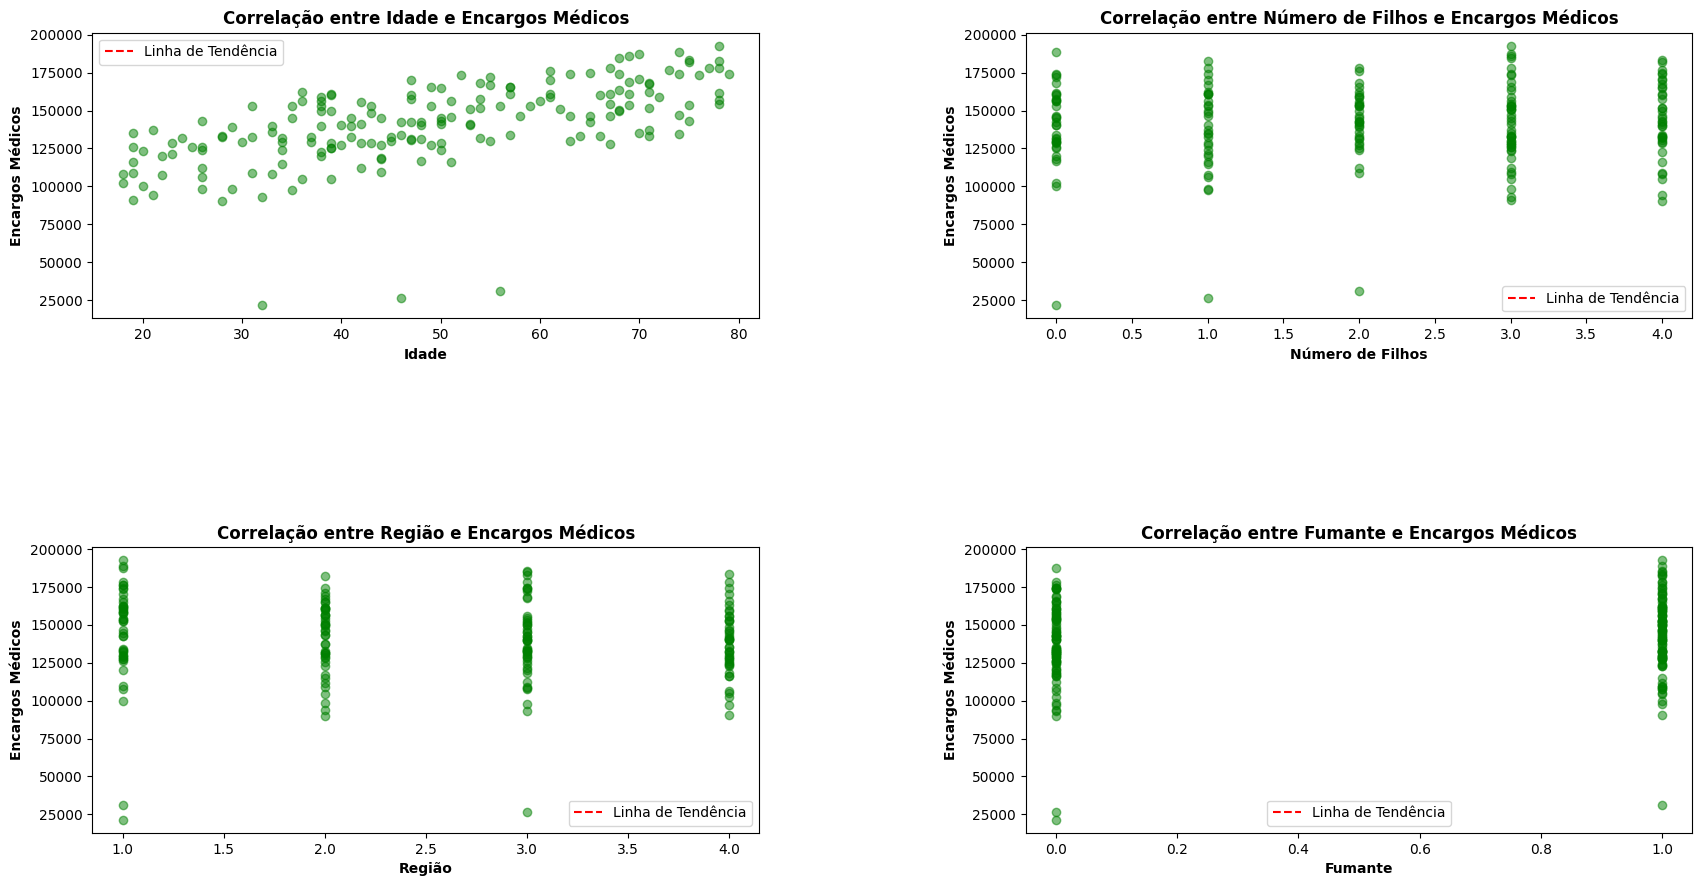

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.8)

montar_grafico_correlacao(dados['Idade'], dados['Encargos'], axs[0,0],
                          'Correlação entre Idade e Encargos Médicos', 'Idade', 'Encargos Médicos')

montar_grafico_correlacao(dados['Filhos'], dados['Encargos'], axs[0,1],
                          'Correlação entre Número de Filhos e Encargos Médicos', 'Número de Filhos', 'Encargos Médicos')

# Mapeamento das regiões para valores numéricos
regiao_numerica = {'sudoeste': 1, 'sudeste': 2, 'nordeste': 3, 'noroeste': 4}

# Convertendo os valores da coluna 'Região' para valores numéricos usando o mapeamento
dados['Região_numerica'] = dados['Região'].map(regiao_numerica)

# Substituir valores 'sim' e 'não' por 1 e 0
dados['Fumante'] = dados['Fumante'].map({'sim': 1, 'não': 0})

montar_grafico_correlacao(dados['Região_numerica'], dados['Encargos'], axs[1,0],
                          'Correlação entre Região e Encargos Médicos', 'Região', 'Encargos Médicos')

montar_grafico_correlacao(dados['Fumante'], dados['Encargos'], axs[1,1],
                          'Correlação entre Fumante e Encargos Médicos', 'Fumante', 'Encargos Médicos')

# Mostra os gráficos
plt.show()

# Calcula a correlação
#correlacao_filhos_encargos = dados['Filhos'].corr(dados['Encargos'])
#print("\nCorrelação entre Número de Filhos e Encargos Médicos:\n", correlacao_filhos_encargos)
#print('-' * 100)